# Experiment 03: FreeForm & BioMimetic Discovery

**Objective:** Move beyond simple geometric shapes to discover complex, non-intuitive injection strategies.

We investigate two advanced paradigms:
1.  **BioMimetic (The Heartbeat):** A parametric waveform inspired by cardiovascular flows (Systolic pump + Dicrotic notch reflection).
2.  **FreeForm (The AI Discovery):** We treat the injection schedule $P(t)$ as a trainable vector of size $T$. The AI controls pressure at *every single time step*, allowing it to react to microscopic events like salt precipitation precursors.

**Consistency:** Uses the centralized `physics.py` engine.

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import optax
import matplotlib.pyplot as plt
import numpy as np
import physics

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

print(f"Physics Engine Loaded. Grid: {physics.NX}x{physics.NY}")

Physics Engine Loaded. Grid: 100x50


## 1. Load Baseline Data

In [2]:
# Constants
NX, NY = physics.NX, physics.NY
TIME_STEPS = 1000

# Load Baseline
try:
    baseline_data = np.load("baseline_saturation_history.npy", allow_pickle=True).item()
    baseline_curve = baseline_data['pressure_mode_saturation']
    baseline_final_sat = baseline_curve[-1]
    print(f"Baseline Loaded. Final Saturation: {baseline_final_sat:.4f}")
except:
    print("Warning: Baseline file not found. Using placeholder.")
    baseline_curve = jnp.zeros(TIME_STEPS)
    baseline_final_sat = 0.0

# Initial State (Same as previous experiments)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.25, shape=(NX, NY)).astype(jnp.float64)
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0) 

rho_init = jnp.ones((NX, NY)) * physics.RHO_BRINE
u_init = jnp.zeros((NX, NY))
f_init = physics.get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5

state_init = (f_init, salt_init, mask_init)

Baseline Loaded. Final Saturation: 0.3936


In [3]:
# --- APPENDIX A: SIMULATION CONFIGURATION ---
# Dynamically pulls values from physics.py
print("="*60)
print("       APPENDIX A: SIMULATION CONFIGURATION")
print("="*60)
print(f"1. Domain Geometry (Source: physics.py)")
print(f"   - Grid Dimensions:        {physics.NX} x {physics.NY}")
print(f"   - Simulation Duration:    {TIME_STEPS} steps")
print(f"\n2. Fluid Parameters")
print(f"   - Brine Density:          {physics.RHO_BRINE:.2f}")
print(f"   - CO2 Init Density:       {physics.RHO_CO2_INIT:.2f}")
print(f"   - Viscosity (Tau CO2):    {physics.TAU_CO2:.2f}")
print(f"\n3. Reactive Transport")
print(f"   - Salt Diffusion (D):     {physics.D_SALT:.3f}")
print(f"   - Solubility Limit (Ksp): {physics.K_SP:.2f}")
print("="*60)

       APPENDIX A: SIMULATION CONFIGURATION
1. Domain Geometry (Source: physics.py)
   - Grid Dimensions:        100 x 50
   - Simulation Duration:    1000 steps

2. Fluid Parameters
   - Brine Density:          1.00
   - CO2 Init Density:       0.10
   - Viscosity (Tau CO2):    0.90

3. Reactive Transport
   - Salt Diffusion (D):     0.050
   - Solubility Limit (Ksp): 1.10


## 2. Strategy 1: BioMimetic (Heartbeat) Optimization
We model the pressure as a periodic "Pulsatile Flow" with a secondary "Dicrotic Notch" peak.

In [4]:
def get_time_array(steps):
    return jnp.linspace(0, steps, steps)

@jit
def waveform_biomimetic(t, params):
    # params: [P_base, Amp_Systolic, Amp_Notch, Period]
    p_base, amp_sys, amp_notch, period = params
    period = jnp.maximum(period, 10.0)
    
    # Normalized cycle time (0 to 1)
    t_cycle = (t % period) / period
    
    # 1. Systole (Main Pump): Sharp Gaussian at 20% of cycle
    systole = jnp.exp(-0.5 * ((t_cycle - 0.2) / 0.08)**2)
    
    # 2. Dicrotic Notch (Reflection): Smaller Gaussian at 50% of cycle
    notch = jnp.exp(-0.5 * ((t_cycle - 0.5) / 0.08)**2)
    
    return p_base + amp_sys * systole + amp_notch * notch

# Reuse loss function from Ex 02
def loss_biomimetic(params, waveform_func):
    t_array = get_time_array(TIME_STEPS)
    p_schedule = waveform_func(t_array, params)
    final_state, (s_hist, _) = lax.scan(physics.lbm_step_pressure, state_init, p_schedule)
    return 1.0 - s_hist[-1], (s_hist, p_schedule)

# Run BioMimetic Optimization
print("Running BioMimetic Optimization...")
init_bio = jnp.array([0.02, 0.03, 0.015, 150.0]) # Guess: Base, Sys, Notch, Period

optimizer = optax.adam(0.01)
opt_state = optimizer.init(init_bio)
params_bio = init_bio

grad_fn_bio = value_and_grad(loss_biomimetic, has_aux=True)

best_sat_bio = 0.0
res_bio = None

for i in range(50):
    (loss, (s_hist, p_sched)), grads = grad_fn_bio(params_bio, waveform_biomimetic)
    updates, opt_state = optimizer.update(grads, opt_state)
    params_bio = optax.apply_updates(params_bio, updates)
    
    if (1.0 - loss) > best_sat_bio:
        best_sat_bio = 1.0 - loss
        res_bio = (s_hist, p_sched, params_bio)
    if i % 10 == 0:
        print(f"BioMimetic Epoch {i}: Sat={1.0-loss:.4f}")

s_bio, p_bio, final_params_bio = res_bio
print(f"BioMimetic Best Saturation: {best_sat_bio:.4f}")

Running BioMimetic Optimization...
BioMimetic Epoch 0: Sat=0.3941
BioMimetic Epoch 10: Sat=0.3931
BioMimetic Epoch 20: Sat=0.3937
BioMimetic Epoch 30: Sat=0.3950
BioMimetic Epoch 40: Sat=0.3947
BioMimetic Best Saturation: 0.3953


## 3. Strategy 2: FreeForm Optimization (The AI Discovery)
Here, we optimize the entire `p_schedule` array ($T=1000$ parameters) directly.
We add **Total Variation (TV)** regularization to prevent the AI from generating high-frequency noise that is physically impossible to pump.

In [5]:
def loss_freeform(p_schedule_params):
    # Enforce positivity and safety limits
    p_safe = jnp.clip(p_schedule_params, 0.0, 0.08)
    
    # Physics Run
    final_state, (s_hist, _) = lax.scan(physics.lbm_step_pressure, state_init, p_safe)
    
    # Primary Loss: Maximize Saturation
    sat_loss = 1.0 - s_hist[-1]
    
    # Regularization 1: Total Variation (Smoothness)
    # Penalizes jitter: sum(|P_t+1 - P_t|)
    tv_loss = jnp.mean(jnp.abs(p_safe[1:] - p_safe[:-1]))
    
    # Regularization 2: Energy Cost
    energy_loss = jnp.mean(p_safe**2)
    
    # Composite Loss
    total_loss = sat_loss + 0.5 * tv_loss + 0.1 * energy_loss
    return total_loss, (s_hist, p_safe)

print("Running FreeForm Optimization (1000 Params)...")
# Initialize with the Baseline Constant Pressure (0.03)
init_free = jnp.ones(TIME_STEPS) * 0.03

# Use a lower learning rate for high-dim optimization
optimizer_ff = optax.adam(0.005)
opt_state_ff = optimizer_ff.init(init_free)
params_free = init_free

grad_fn_ff = value_and_grad(loss_freeform, has_aux=True)

best_sat_free = 0.0
res_free = None

for i in range(80): # More epochs for high dimensional space
    (loss, (s_hist, p_sched)), grads = grad_fn_ff(params_free)
    updates, opt_state_ff = optimizer_ff.update(grads, opt_state_ff)
    params_free = optax.apply_updates(params_free, updates)
    
    # Actual saturation (ignoring reg loss for logging)
    current_sat = s_hist[-1]
    
    if current_sat > best_sat_free:
        best_sat_free = current_sat
        res_free = (s_hist, p_sched, params_free)
        
    if i % 10 == 0:
        print(f"FreeForm Epoch {i}: Sat={current_sat:.4f}")

s_free, p_free, final_params_free = res_free
print(f"FreeForm Best Saturation: {best_sat_free:.4f}")

Running FreeForm Optimization (1000 Params)...
FreeForm Epoch 0: Sat=0.3936
FreeForm Epoch 10: Sat=0.3941
FreeForm Epoch 20: Sat=0.3936
FreeForm Epoch 30: Sat=0.3941
FreeForm Epoch 40: Sat=0.3939
FreeForm Epoch 50: Sat=0.3941
FreeForm Epoch 60: Sat=0.3944
FreeForm Epoch 70: Sat=0.3944
FreeForm Best Saturation: 0.3944


## 4. Visualization & Comparison
Comparing the "Intelligent" shapes against the Baseline.

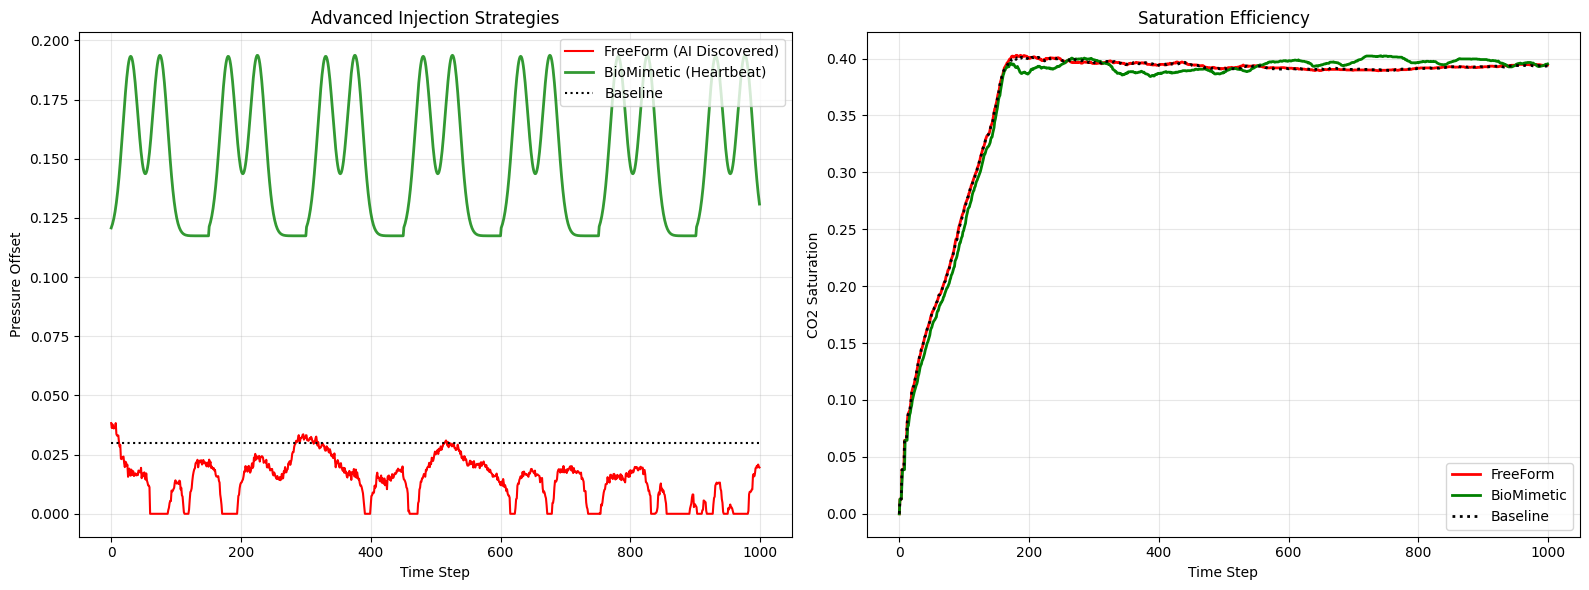

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: The Discovered Strategies (Pressure Schedules)
ax[0].plot(p_free, 'r-', linewidth=1.5, label='FreeForm (AI Discovered)')
ax[0].plot(p_bio, 'g-', linewidth=2, alpha=0.8, label='BioMimetic (Heartbeat)')
ax[0].plot(jnp.ones(TIME_STEPS)*0.03, 'k:', label='Baseline')
ax[0].set_title("Advanced Injection Strategies")
ax[0].set_ylabel("Pressure Offset")
ax[0].set_xlabel("Time Step")
ax[0].legend(loc='upper right')
ax[0].grid(True, alpha=0.3)

# Plot 2: Efficiency Comparison
ax[1].plot(s_free, 'r-', linewidth=2, label='FreeForm')
ax[1].plot(s_bio, 'g-', linewidth=2, label='BioMimetic')
ax[1].plot(baseline_curve, 'k:', linewidth=2, label='Baseline')

ax[1].set_title("Saturation Efficiency")
ax[1].set_ylabel("CO2 Saturation")
ax[1].set_xlabel("Time Step")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# --- APPENDIX B: OPTIMIZED RESULTS SUMMARY ---
print("="*60)
print("       APPENDIX B: OPTIMIZED RESULTS SUMMARY")
print("="*60)
print(f"{ 'STRATEGY':<20} | { 'FINAL SAT':<12} | { 'GAIN':<10} | { 'TYPE':<10}")
print("-"*60)

def print_row(name, sat, mode):
    gain = (sat - baseline_final_sat) / baseline_final_sat * 100
    print(f"{name:<20} | {sat:.4f}       | {gain:+.2f}%    | {mode}")

print_row("Baseline", baseline_final_sat, "Static")
print_row("BioMimetic", s_bio[-1], "Parametric")
print_row("FreeForm", s_free[-1], "AI-Vector")

print("-"*60)
print("BIOMIMETIC PARAMETERS:")
print(f"   Period: {final_params_bio[3]:.1f} steps, Systolic Amp: {final_params_bio[1]:.4f}")
print("="*60)

       APPENDIX B: OPTIMIZED RESULTS SUMMARY
STRATEGY             | FINAL SAT    | GAIN       | TYPE      
------------------------------------------------------------
Baseline             | 0.3936       | +0.00%    | Static
BioMimetic           | 0.3953       | +0.42%    | Parametric
FreeForm             | 0.3944       | +0.20%    | AI-Vector
------------------------------------------------------------
BIOMIMETIC PARAMETERS:
   Period: 150.4 steps, Systolic Amp: 0.0775


## 5. Visualization: Fluid Maps (FreeForm Results)
Visualizing the fluid distribution achieved by the FreeForm strategy.

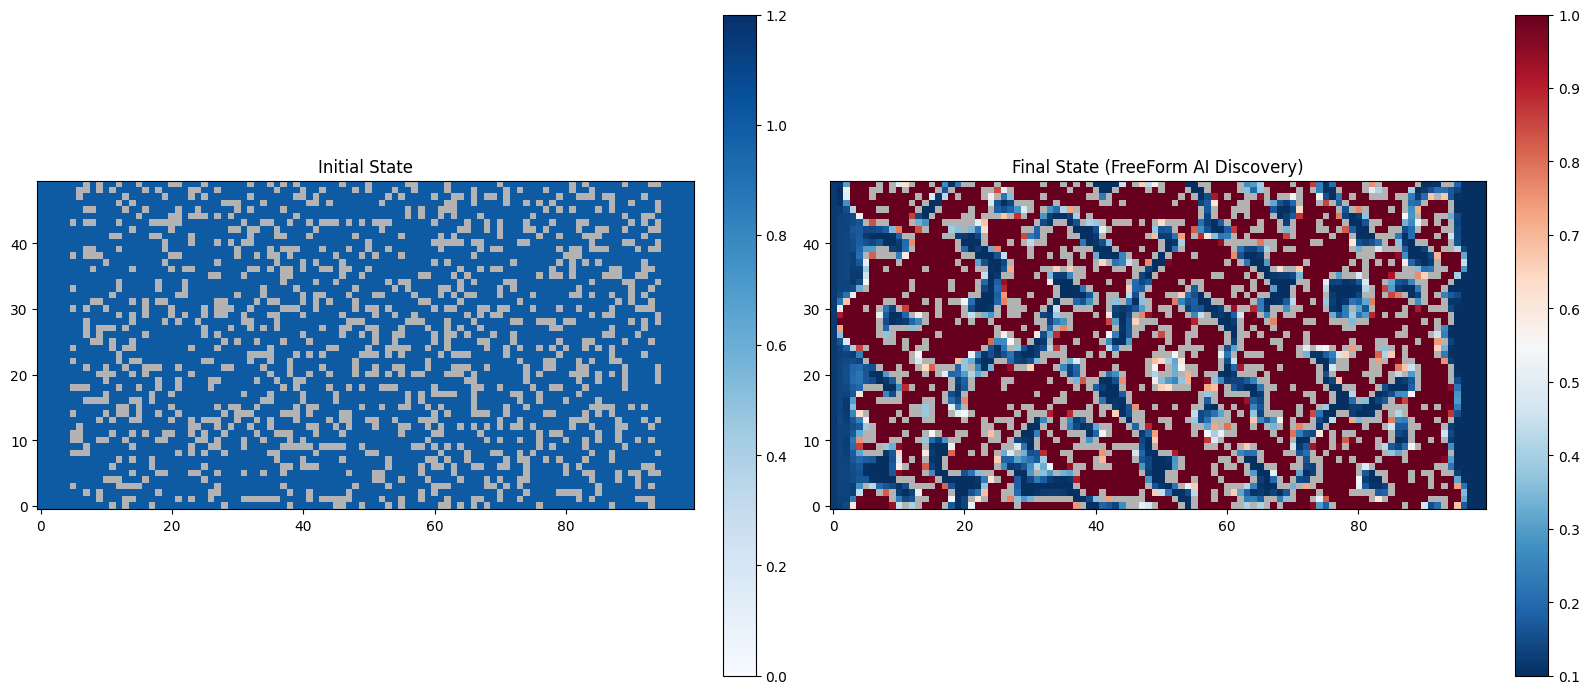

In [8]:
# 1. Re-run FreeForm Physics
final_state_free, _ = lax.scan(physics.lbm_step_pressure, state_init, p_free)
f_final, salt_final, mask_final = final_state_free
rho_final = jnp.sum(f_final, axis=-1)

# 2. Prepare Plotting Data
f_init, _, mask_init_val = state_init
rho_init_val = jnp.sum(f_init, axis=-1)

rho_init_masked = np.ma.masked_where(mask_init_val > 0.5, rho_init_val)
rho_final_masked = np.ma.masked_where(mask_final > 0.5, rho_final)

# 3. Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Map A: Initial
ax[0].imshow(mask_init_val.T, cmap='gray_r', origin='lower', alpha=0.3)
im0 = ax[0].imshow(rho_init_masked.T, cmap='Blues', origin='lower', vmin=0.0, vmax=1.2)
ax[0].set_title(f"Initial State")
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

# Map B: FreeForm Final
ax[1].imshow(mask_final.T, cmap='gray_r', origin='lower', alpha=0.3)
im1 = ax[1].imshow(rho_final_masked.T, cmap='RdBu_r', origin='lower', 
                   vmin=physics.RHO_CO2_INIT, vmax=physics.RHO_BRINE)
ax[1].set_title(f"Final State (FreeForm AI Discovery)")
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()